# Cho dữ liệu spam.csv chứa thông tin là nội dung các email. 
# Bộ dữ liệu này có thể được sử dụng để dự đoán một email gửi đến là ham hay spam.

## Yêu cầu:
* Đọc dữ liệu, tìm hiểu sơ bộ về dữ liệu
* Chọn phương pháp để chuẩn hóa dữ liệu và thực hiện việc chuẩn hóa.
* Áp dụng Logistic Regression để xác định một email được gửi đến là ham hay spam
* Với nội dung là: ["Hi, I have received your email. I will send my assigment on time", "Valid 12 hours only."] thì sẽ là ham hay spam?

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [75]:
mail = pd.read_csv('data9/Ex3_Spam_vs_Ham/spam.csv', encoding='latin')
mail

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## Data Standardization (Using Tf-Idf)

In [76]:
y = pd.get_dummies(mail['v1'], drop_first=True).astype('float64').to_numpy().ravel()
x = mail['v2'].replace('([^a-zA-Z0-9])', ' ', regex=True).replace('(\s+)', ' ', regex=True).str.lower()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_110479/2536335211.py:2: SyntaxWarning: invalid escape sequence '\s'
  x = mail['v2'].replace('([^a-zA-Z0-9])', ' ', regex=True).replace('(\s+)', ' ', regex=True).str.lower()


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

In [84]:
#tfidf =  TfidfVectorizer(stop_words='english')
#x_tfidf = tfidf.fit_transform(x).toarray()

cv = CountVectorizer(stop_words='english')
x_cv = cv.fit_transform(x).toarray()

x_train, x_test, y_train, y_test = train_test_split(x_cv, y, test_size=0.2, random_state=1)

x_train_resamp, y_train_resamp = SMOTE(random_state=1).fit_resample(x_train, y_train)

Accuracy score of LogReg model on test set: 0.9067264573991032

Confusion matrix of LogReg model:
 [[881  95]
 [  9 130]]

Classification report of LogReg model:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       976
         1.0       0.58      0.94      0.71       139

    accuracy                           0.91      1115
   macro avg       0.78      0.92      0.83      1115
weighted avg       0.94      0.91      0.92      1115


ROC_AUC score of LogReg model: 0.9756825686991392



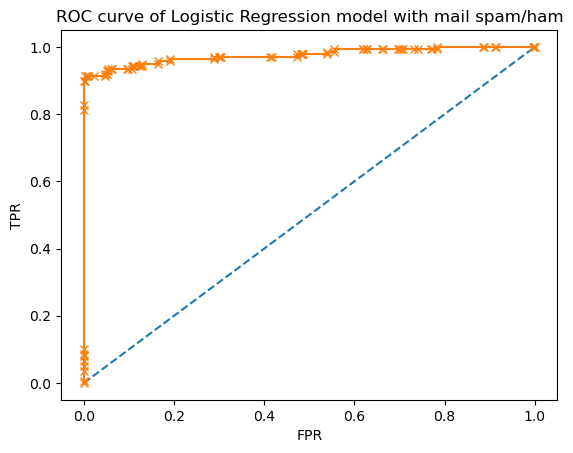

In [85]:
logreg_mail = LogisticRegression(solver='liblinear').fit(x_train_resamp, y_train_resamp)

y_pred_test = logreg_mail.predict(x_test)
y_proba_test = logreg_mail.predict_proba(x_test)

print(f'Accuracy score of LogReg model on test set: {accuracy_score(y_test, y_pred_test)}')
print()
print(f'Confusion matrix of LogReg model:\n {confusion_matrix(y_test, y_pred_test)}')
print()
print(f'Classification report of LogReg model:\n {classification_report(y_test, y_pred_test)}')
print()
print(f'ROC_AUC score of LogReg model: {roc_auc_score(y_test, y_proba_test[:,1])}')
print()

fpr, tpr, threshold = roc_curve(y_test, y_proba_test[:,1])
plt.plot([0,1], [0,1], linestyle='--', label='Reference line')
plt.plot(fpr, tpr, marker='x', label='ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve of Logistic Regression model with mail spam/ham')
plt.show()

In [86]:
new_input_mail = pd.Series(["Hi, I have received your email. I will send my assigment on time", "Valid 12 hours only."])
new_input_mail = new_input_mail.replace('([^a-zA-Z0-9])', ' ', regex=True).replace('(\s+)', ' ', regex=True).str.lower()

new_input_mail

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_110479/1946674952.py:2: SyntaxWarning: invalid escape sequence '\s'
  new_input_mail = new_input_mail.replace('([^a-zA-Z0-9])', ' ', regex=True).replace('(\s+)', ' ', regex=True).str.lower()


0    hi i have received your email i will send my a...
1                                 valid 12 hours only 
dtype: object

In [87]:
logreg_mail.predict(cv.transform(new_input_mail))

array([0., 1.])

## <span style='color:yellow'> build Pipeline

In [92]:
from imblearn.pipeline import Pipeline

pipe_mail = Pipeline([
    ("CountVectorizer", CountVectorizer(stop_words='english')),
    ("OverSampling SMOTE", SMOTE()),
    ("LogReg model", LogisticRegression(solver='liblinear'))
])

pipe_mail.fit(x, y)

Pipeline(steps=[('CountVectorizer', CountVectorizer(stop_words='english')),
                ('OverSampling SMOTE', SMOTE()),
                ('LogReg model', LogisticRegression(solver='liblinear'))])

In [95]:
print("New mail input:\n",new_input_mail)
print()
print("Predict with pipeline")
pipe_mail.predict(new_input_mail)

New mail input:
 0    hi i have received your email i will send my a...
1                                 valid 12 hours only 
dtype: object

Predict with pipeline


array([0., 1.])